# Simple Azure ML Pipeline Tutorial using cats vs dogs dataset

In this notebook-based tutorial, we will create and run a Azure ML pipeline
for a simple cats vs dogs classification model.
The pipeline will consist of three essential Azure ML components: ExampleGen,
Trainer and Pusher. The pipeline includes the most minimal ML workflow like
importing data, training a model and pushing the trained model to the local envirinment.

Please see
[Understanding TFX Pipelines](https://www.tensorflow.org/tfx/guide/understanding_tfx_pipelines)
to learn more about various concepts in TFX.

## Set Up
We first need to install the TFX Python package and download
the dataset which we will use for our model.

In [ ]:
!pip install azure-ai-ml

In [ ]:
!pip install azureml

In [4]:
# Handle to the workspace
from azure.ai.ml import MLClient

# Authentication package
from azure.identity import DefaultAzureCredential, InteractiveBrowserCredential

try:
    credential = DefaultAzureCredential()
    # Check if given credential can get token successfully.
    credential.get_token("https://management.azure.com/.default")
except Exception as ex:
    # Fall back to InteractiveBrowserCredential in case DefaultAzureCredential not work
    credential = InteractiveBrowserCredential()

In [5]:
# Get a handle to the workspace
ml_client = MLClient(
    credential=credential,
    subscription_id="c6c6e76b-a64b-4a2e-87e4-4122626f39c7",
    resource_group_name="exjobb-t2304-11614",
    workspace_name="ritko75_exjobb",
)

## Download the cat vs dog dataset
Because TFX ExampleGen reads inputs from a directory, we need to create a
directory and copy dataset to it.

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
'chmod 600 /root/.kaggle/kaggle.json'
!kaggle datasets download -d salader/dogs-vs-cats
!unzip dogs-vs-cats.zip
!rm -rf test train dogs-vs-cats.zip

## Reduce size of the dataset (optional)
We reduce size of the dataset by removing the images from both train and test folders to speed up the ML process. Train images decreas from 20000 images to 2000 and test images decreas from 5000 to 500 images to make the process faster (OBS: just for testing).

In [11]:
!ls -1 dogs_vs_cats/train/dogs/* | tail -n +1001 | xargs rm 
!ls -1 dogs_vs_cats/train/cats/* | tail -n +1001 | xargs rm

!ls -1 dogs_vs_cats/test/dogs/* | tail -n +251 | xargs rm 
!ls -1 dogs_vs_cats/test/cats/* | tail -n +251 | xargs rm 

In [2]:
import os

components_dir = "./components"
os.makedirs(components_dir, exist_ok=True)


## Set up necessary variables

There are some variables used to define a pipeline. You can customize these
variables as you want. By default all output from the pipeline will be
generated under the current directory.

In [3]:
import os

_components_base_dir = 'components'
_data_prep_file = os.path.join(_components_base_dir, 'dataprep.py')
_trainer_file = os.path.join(_components_base_dir, 'trainer.py')
_transform_file = os.path.join(_components_base_dir, 'transform.py')

print(_data_prep_file)


IMG_HEIGHT = 150
IMG_WIDTH = 150
batch_size = 128
PIPELINE_NAME = 'dogs_vs_cats_pipeline'
PIPELINE_ROOT = os.path.join('pipelines', PIPELINE_NAME)
SERVING_MODEL_DIR = os.path.join('serving_model', PIPELINE_NAME)
METADATA_PATH = os.path.join('metadata', PIPELINE_NAME, 'cat&dog_md.db')

components/dataprep.py


In [4]:
data_root ='dogs_vs_cats'
train_dir = os.path.join(data_root, 'train')
validation_dir = os.path.join(data_root, 'test')

train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val


print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)
print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1002
total training dog images: 1002
total validation cat images: 252
total validation dog images: 252
--
Total training images: 2004
Total validation images: 504


## Write model training code

We will create a simple CNN (Convolutional Neural Network) model for cats vs dogs classification using TensorFlow Keras
API. This model training code will be saved to a separate file.

For model training code we found this tutorial on Kaggle
[here](https://www.kaggle.com/code/alpaca0984/dogs-vs-cats-tensorflow-2-0-on-google-colab). You need to write a Python file
containing `run_fn` function, which is the entrypoint for the `Trainer`
component.

In [ ]:
from azureml.core import Dataset, Workspace, Datastore

ws = Workspace.from_config()

datastore = ws.get_default_datastore()

datastore.upload(src_dir='./dogs_vs_cats', target_path='dogs_vs_cats')

train_dataset = Dataset.File.from_files((datastore, 'dogs_vs_cats/train'), validate=True)

test_dataset = Dataset.File.from_files((datastore, 'dogs_vs_cats/test'), validate=True)


train_dataset = train_dataset.register(workspace=ws,
                                    name='train_dataset',
                                    description='training dataset',
                                    create_new_version=True)

test_dataset = test_dataset.register(workspace=ws,
                                    name='test_dataset',
                                    description='test dataset',
                                        create_new_version=True)

In [23]:
%%writefile {_data_prep_file}

import matplotlib.pyplot as plt
import os
import gzip
from typing import List
from azureml.core import Dataset, Workspace, Datastore
from azure.ai.ml.entities import Data
from azure.ai.ml.constants import AssetTypes



_LABEL_KEY = 'label'
IMG_HEIGHT = 150
IMG_WIDTH = 150
batch_size = 128

_TRAIN_DATA_SIZE = 2000
_TEST_DATA_SIZE = 500



def main():
    
    
    return

if __name__ == "__main__":
    main()


Overwriting {_data_prep_file}


## Define the pipeline
We define the ML pipeline here. The components of the pipeline are: ImportExampleGen for ingesting the images into the pipeline, Trainer for training the model and Pusher component for serving the model into production environment (in this example the model is pushed in the local environment).

For ingesting the image dataset into the pipeline, we got help from this github repository [github](https://github.com/tensorflow/tfx/blob/master/tfx/examples/cifar10/cifar10_pipeline_native_keras.py)

In [10]:
from tfx.proto import example_gen_pb2
from tfx.components import ImportExampleGen


def _create_pipeline(pipeline_name: str, pipeline_root: str,
                     module_file: str, serving_model_dir: str,
                     metadata_path: str) -> tfx.dsl.Pipeline:
  print("Pipeline creation is running...\n\n\n")

  """Creates a three component penguin pipeline with TFX."""
 
  input_config = example_gen_pb2.Input(splits=[
      example_gen_pb2.Input.Split(name='train', pattern='train/*'),
      example_gen_pb2.Input.Split(name='eval', pattern='test/*')
  ])

  # Brings data into the pipeline.
  example_gen = ImportExampleGen(
      input_base='/content/dataset', input_config=input_config)
  
  # Uses user-provided Python function that trains a model.
  trainer = tfx.components.Trainer(
      module_file=module_file,
      examples=example_gen.outputs['examples'],
      )
  
  # Pushes the model to a filesystem destination.
  pusher = tfx.components.Pusher(
      model=trainer.outputs['model'],
      push_destination=tfx.proto.PushDestination(
          filesystem=tfx.proto.PushDestination.Filesystem(
              base_directory=serving_model_dir)))

  # Following three components will be included in the pipeline.
  components = [
      example_gen,
      trainer,
      pusher,
  ]

  return tfx.dsl.Pipeline(
      pipeline_name=pipeline_name,
      pipeline_root=pipeline_root,
      metadata_connection_config=tfx.orchestration.metadata
      .sqlite_metadata_connection_config(metadata_path),
      components=components)

## Run the pipeline

TFX supports multiple orchestrators to run pipelines.
In this tutorial we will use `LocalDagRunner` which is included in the TFX
Python package and runs pipelines on local environment.
We often call TFX pipelines "DAGs" which stands for directed acyclic graph.

`LocalDagRunner` provides fast iterations for development and debugging.
TFX also supports other orchestrators including Kubeflow Pipelines and Apache
Airflow which are suitable for production use cases.

See
[TFX on Cloud AI Platform Pipelines](https://www.tensorflow.org/tfx/tutorials/tfx/cloud-ai-platform-pipelines)
or
[TFX Airflow Tutorial](https://www.tensorflow.org/tfx/tutorials/tfx/airflow_workshop)
to learn more about other orchestration systems.

Pipeline creation is running...





Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 75, 75, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                    

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Epoch 1/32
15/15 [==============================] - 22s 265ms/step - loss: 11.2490 - accuracy: 0.5078 - val_loss: 0.6930 - val_accuracy: 0.5078
Epoch 2/32
15/15 [==============================] - 4s 290ms/step - loss: 0.6929 - accuracy: 0.5042 - val_loss: 0.6916 - val_accuracy: 0.5234
Epoch 3/32
15/15 [==============================] - 5s 314ms/step - loss: 0.6985 - accuracy: 0.5193 - val_loss: 0.6935 - val_accuracy: 0.4948
Epoch 4/32
15/15 [==============================] - 5s 320ms/step - loss: 0.6927 - accuracy: 0.5010 - val_loss: 0.6932 - val_accuracy: 0.4844
Epoch 5/32
15/15 [==============================] - 4s 246ms/step - loss: 0.6932 - accuracy: 0.4984 - val_loss: 0.6931 - val_accuracy: 0.5156
Epoch 6/32
15/15 [==============================] - 4s 242ms/step - loss: 0.6930 - accuracy: 0.5161 - val_loss: 0.6930 - val_accuracy: 0.4896
Epoch 7/32
15/15 [==============================] - 4s 290ms/step - loss: 0.6929 - accuracy: 0.4979 - val_loss: 0.6925 - val_accuracy: 0.5443
Epoc

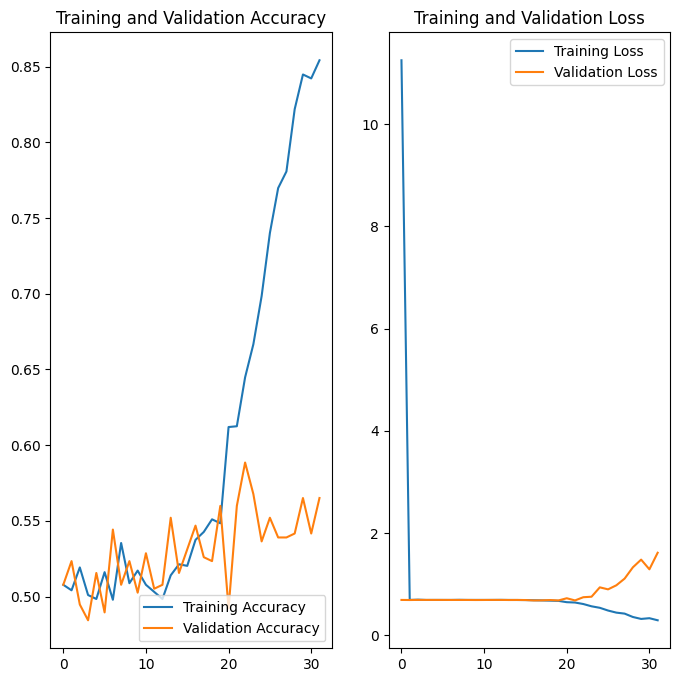

In [11]:
tfx.orchestration.LocalDagRunner().run(
  _create_pipeline(
      pipeline_name=PIPELINE_NAME,
      pipeline_root=PIPELINE_ROOT,
      module_file=_trainer_module_file,
      serving_model_dir=SERVING_MODEL_DIR,
      metadata_path=METADATA_PATH))

The pusher component pushes the trained model to the `SERVING_MODEL_DIR` which
is the `serving_model/dogs_vs_cats_pipeline` directory if you did not change the
variables in the previous steps. You can see the result from the file browser
in the left-side panel in Colab, or using the following command:

In [12]:
# List files in created model directory.
!find {SERVING_MODEL_DIR}

serving_model/dogs_vs_cats_pipeline
serving_model/dogs_vs_cats_pipeline/1682412575
serving_model/dogs_vs_cats_pipeline/1682412575/saved_model.pb
serving_model/dogs_vs_cats_pipeline/1682412575/keras_metadata.pb
serving_model/dogs_vs_cats_pipeline/1682412575/fingerprint.pb
serving_model/dogs_vs_cats_pipeline/1682412575/variables
serving_model/dogs_vs_cats_pipeline/1682412575/variables/variables.index
serving_model/dogs_vs_cats_pipeline/1682412575/variables/variables.data-00000-of-00001
serving_model/dogs_vs_cats_pipeline/1682412575/assets
